In [1]:
%load_ext autoreload
%autoreload 2

# A pronounced loss of tree crown foliation results in multi-year growth reduction

We train model to predict the growth of trees during a given period of 4-6 years based on the following features:

| feature            | description                                  | level |
|--------------------|----------------------------------------------|-------|
| diameter_end       | Diameter at the end of the period            | tree  |
| defoliation_max    | Maximum defoliation of the growth period     | tree  |
| defoliation_min    | Minimum defoliation of the growth period     | tree  |
| defoliation_mean   | Mean defoliation of the growth period        | tree  |
| defoliation_median | Median defoliation of the growth period      | tree  |
| social_class_min   | Minimum social class of the growth period    | tree  |
| plot_latitude      | Latitude of the plot                         | plot  |
| plot_longitude     | Longitude of the plot                        | plot  |
| plot_slope         | Slope of the plot                            | plot  |
| plot_orientation   | Orientation of the plot                      | plot  |
| plot_altitude      | Altitude of the plot                         | plot  |
| dep_ph             | Deposition pH                                | plot  |
| dep_cond           | Deposition conductivity                      | plot  |
| dep_k              | Deposition potassium (K)                     | plot  |
| dep_ca             | Deposition calcium (Ca)                      | plot  |
| dep_mg             | Deposition magnesium (Mg)                    | plot  |
| dep_na             | Deposition sodium (Na)                       | plot  |
| dep_n_nh4          | Deposition ammonium (NH4)                    | plot  |
| dep_cl             | Deposition chloride (Cl)                     | plot  |
| dep_n_no3          | Deposition nitrate (NO3)                     | plot  |
| dep_s_so4          | Deposition sulfate (SO4)                     | plot  |
| dep_alk            | Deposition alkalinity                        | plot  |
| dep_n_tot          | Deposition total nitrogen (N)                | plot  |
| dep_doc            | Deposition dissolved organic carbon (DOC)    | plot  |
| dep_al             | Deposition aluminium (Al)                    | plot  |
| dep_mn             | Deposition manganese (Mn)                    | plot  |
| dep_fe             | Deposition iron (Fe)                         | plot  |
| dep_p_po4          | Deposition phosphate (PO4)                   | plot  |
| dep_cu             | Deposition copper (Cu)                       | plot  |
| dep_zn             | Deposition zinc (Zn)                         | plot  |
| dep_hg             | Deposition mercury (Hg)                      | plot  |
| dep_pb             | Deposition lead (Pb)                         | plot  |
| dep_co             | Deposition cobalt (Co)                       | plot  |
| dep_ni             | Deposition nickel (Ni)                       | plot  |
| dep_cd             | Deposition cadmium (Cd)                      | plot  |
| dep_s_tot          | Deposition total sulfur (S)                  | plot  |
| dep_c_tot          | Deposition total carbon (C)                  | plot  |
| dep_n_org          | Deposition organic nitrogen (N)              | plot  |
| dep_p_tot          | Deposition total phosphorus (P)              | plot  |
| dep_cr             | Deposition chromium (Cr)                     | plot  |
| dep_n_no2          | Deposition nitrite (NO2)                     | plot  |
| ss_ph              | Soil solution pH                             | plot  |
| ss_cond            | Soil solution conductivity                   | plot  |
| ss_k               | Soil solution potassium (K)                  | plot  |
| ss_ca              | Soil solution calcium (Ca)                   | plot  |
| ss_mg              | Soil solution magnesium (Mg)                 | plot  |
| ss_n_no3           | Soil solution nitrate (NO3)                  | plot  |
| ss_s_so4           | Soil solution sulfate (SO4)                  | plot  |
| ss_alk             | Soil solution alkalinity                     | plot  |
| ss_al              | Soil solution aluminium (Al)                 | plot  |
| ss_doc             | Soil solution dissolved organic carbon (DOC) | plot  |
| ss_na              | Soil solution sodium (Na)                    | plot  |
| ss_n_nh4           | Soil solution ammonium (NH4)                 | plot  |
| ss_cl              | Soil solution chloride (Cl)                  | plot  |
| ss_n_tot           | Soil solution total nitrogen (N)             | plot  |
| ss_fe              | Soil solution iron (Fe)                      | plot  |
| ss_mn              | Soil solution manganese (Mn)                 | plot  |
| ss_al_labile       | Soil solution labile aluminium (Al)          | plot  |
| ss_p               | Soil solution phosphorus (P)                 | plot  |
| ss_cr              | Soil solution chromium (Cr)                  | plot  |
| ss_ni              | Soil solution nickel (Ni)                    | plot  |
| ss_zn              | Soil solution zinc (Zn)                      | plot  |
| ss_cu              | Soil solution copper (Cu)                    | plot  |
| ss_pb              | Soil solution lead (Pb)                      | plot  |
| ss_cd              | Soil solution cadmium (Cd)                   | plot  |
| ss_si              | Soil solution silicon (Si)                   | plot  |
| soph_avg_sdi       | Average species diversity index              | plot  |
| soph_avg_age       | Average age of the trees                     | plot  |
| soph_avg_temp      | Average temperature                          | plot  |
| soph_avg_precip    | Average precipitation                        | plot  |

Here we import key libraries used in the notebook (run `uv sync` and select the corresponding kernel if some of them are missing).

In [2]:
# Main libraries
import shap
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# We will use Polars for data manipulation
import polars as pl

# Casting types from time to time to have a better autocompletion
from typing import cast

from models import (
    train_and_explain,
    optimize_hyperparameters,
    ExperimentResults,
    Species,
    r2_score,
)

from functools import partial

/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from data import prepare_data, load_data

df = load_data("spruce")
X, y = prepare_data(df)

print("all variables:", list(df.columns))

# Compare absolute growth, growth rate, and relative growth rate (to diameter)
df.select("growth", "growth_rate", "growth_rate_rel").describe()

KS Statistic: 0.019460609288104724
P-value: 3.5e-05
all variables: ['tree_id', 'period_start', 'period_end', 'nb_defol_obs', 'defoliation_max', 'defoliation_min', 'defoliation_mean', 'defoliation_median', 'defoliation_last', 'social_class_min', 'social_class_max', 'social_class_mode', 'social_class_last', 'was_dominant', 'was_codominant', 'was_subdominant', 'was_suppressed', 'was_dying', 'survey_year', 'plot_id', 'country_code', 'country', 'tree_species_code', 'specie', 'plot_code', 'tree_number', 'diameter_start', 'diameter_end', 'period_duration_d', 'period_duration_y', 'growth', 'growth_rate', 'growth_rel', 'growth_rate_rel', 'diameter_method_code_start', 'diameter_method_code_end', 'plot_latitude', 'plot_longitude', 'plot_slope', 'plot_orientation', 'plot_altitude', 'dep_ph', 'dep_cond', 'dep_k', 'dep_ca', 'dep_mg', 'dep_na', 'dep_n_nh4', 'dep_cl', 'dep_n_no3', 'dep_s_so4', 'dep_alk', 'dep_n_tot', 'dep_doc', 'dep_al', 'dep_mn', 'dep_fe', 'dep_p_po4', 'dep_cu', 'dep_zn', 'dep_hg', '

statistic,growth,growth_rate,growth_rate_rel
str,f64,f64,f64
"""count""",14456.0,14456.0,14456.0
"""null_count""",0.0,0.0,0.0
"""mean""",1.378998,0.288492,0.008939
"""std""",1.063943,0.222406,0.006793
"""min""",0.0,0.0,0.0
"""25%""",0.61,0.137976,0.004625
"""50%""",1.2,0.246634,0.007706
"""75%""",1.9,0.387471,0.011603
"""max""",18.2,3.658455,0.090439


In [4]:
df.select(
    pl.col("period_duration_y"),
    pl.col("diameter_end"),
    (pl.col("growth") / pl.col("period_duration_y")).alias("growth_rate"),
    pl.col("growth_rate_rel"),
).describe()

statistic,period_duration_y,diameter_end,growth_rate,growth_rate_rel
str,f64,f64,f64,f64
"""count""",14456.0,14456.0,14456.0,14456.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",4.781832,32.843759,0.288492,0.008939
"""std""",0.39843,11.241425,0.222406,0.006793
"""min""",4.00282,5.5,0.0,0.0
"""25%""",4.531236,24.3,0.137976,0.004625
"""50%""",4.870737,31.4,0.246634,0.007706
"""75%""",5.002156,39.9,0.387471,0.011603
"""max""",5.883762,96.3,3.658455,0.090439


We then optimize hyperparameters and train models for every species. We may also select here the type of grouping used by the K-fold validation.

In [5]:
# Predict the 95th percentile of the distribution
# objective = "quantile"
# alpha = 0.50

# Predict the mean of the distribution
objective = "regression"
alpha = None

group_col = "tree_id"
all_species: list[Species] = ["spruce", "pine", "beech", "oak"]
all_results: dict[str, ExperimentResults] = {}

r2_score = partial(r2_score, objective=objective, alpha=alpha)

for species in all_species:
    best_params, best_value = optimize_hyperparameters(
        species, group_col=group_col, objective=objective, alpha=alpha
    )

    all_results[species] = train_and_explain(species, best_params, group_col=group_col)

2025-06-25 23:22:51 - INFO - Loading cached study for spruce with group_col=tree_id.


Training model for spruce
KS Statistic: 0.019460609288104724
P-value: 3.5e-05


/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/pytho

[LightGBM] [Warning] Unknown parameter: min_gain_split[LightGBM] [Warning] Unknown parameter: min_gain_split

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6

[LightGBM] [Warning] lambda_l1 is set=0.07966065640828095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07966065640828095[LightGBM] [Warning] lambda_l1 is set=0.07966065640828095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07966065640828095

[LightGBM] [Warning] lambda_l2 is set=9.619630383153564e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.619630383153564e-06
[LightGBM] [Warning] bagging_fraction is set=0.8391492182321932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8391492182321932
[LightGBM] [Warning] lambda_l2 is set=9.619630383153564e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2

/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=0.07966065640828095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07966065640828095
[LightGBM] [Warning] lambda_l2 is set=9.619630383153564e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.619630383153564e-06
[LightGBM] [Warning] bagging_fraction is set=0.8391492182321932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8391492182321932
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.6091729431805077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6091729431805077
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current 

/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/pytho

[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=0.07966065640828095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07966065640828095
[LightGBM] [Warning] lambda_l2 is set=9.619630383153564e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.619630383153564e-06
[LightGBM] [Warning] bagging_fraction is set=0.8391492182321932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8391492182321932
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.6091729431805077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6091729431805077
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current 

/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/pytho

[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=0.07966065640828095, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07966065640828095
[LightGBM] [Warning] lambda_l2 is set=9.619630383153564e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.619630383153564e-06
[LightGBM] [Warning] bagging_fraction is set=0.8391492182321932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8391492182321932
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.6091729431805077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6091729431805077
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current 

/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/pytho

[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=0.009641923786180697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009641923786180697
[LightGBM] [Warning] lambda_l2 is set=0.03695091204947627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03695091204947627
[LightGBM] [Warning] bagging_fraction is set=0.49677472735704564, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49677472735704564
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.4499111776778275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4499111776778275
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current 

/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/pytho

[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=0.009641923786180697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009641923786180697
[LightGBM] [Warning] lambda_l2 is set=0.03695091204947627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03695091204947627
[LightGBM] [Warning] bagging_fraction is set=0.49677472735704564, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49677472735704564
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.4499111776778275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4499111776778275
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current 

/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/pytho

[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=0.009641923786180697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009641923786180697
[LightGBM] [Warning] lambda_l2 is set=0.03695091204947627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03695091204947627
[LightGBM] [Warning] bagging_fraction is set=0.49677472735704564, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49677472735704564
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.4499111776778275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4499111776778275
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current 

/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/pytho

[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=0.9638889119689331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9638889119689331
[LightGBM] [Warning] lambda_l2 is set=4.185793294213608e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.185793294213608e-05
[LightGBM] [Warning] bagging_fraction is set=0.959313676884527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.959313676884527
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.4971062709606269, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4971062709606269
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current va

/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/pytho

[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=0.9638889119689331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9638889119689331
[LightGBM] [Warning] lambda_l2 is set=4.185793294213608e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.185793294213608e-05
[LightGBM] [Warning] bagging_fraction is set=0.959313676884527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.959313676884527
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.4971062709606269, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4971062709606269
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current va

/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/pytho

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=2.4383300188580455e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4383300188580455e-06
[LightGBM] [Warning] lambda_l2 is set=0.06416006228051954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06416006228051954
[LightGBM] [Warning] bagging_fraction is set=0.6642501512169969, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6642501512169969
[LightGBM] [Warning] min_data_in_leaf 

/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/hybrid-ai-lab/icp-paper/.venv/lib/pytho

## Evaluate model performance for each species

Here we compute the mean and standard deviation of the $R^2$ (coefficient of determination) for all species and folds.

In [6]:
for species, results in all_results.items():
    perf = pl.from_dicts(results.performances).select(
        pl.first().cum_count().alias("fold"), "test_r2", "train_r2"
    )

    r2_mean = perf.select("test_r2").mean().item()
    r2_std = perf.select("test_r2").std().item()

    print(f"Results for {species}")
    print(perf.select(pl.selectors.contains("r2")).describe(percentiles=None))

Results for spruce
shape: (6, 3)
┌────────────┬──────────┬──────────┐
│ statistic  ┆ test_r2  ┆ train_r2 │
│ ---        ┆ ---      ┆ ---      │
│ str        ┆ f64      ┆ f64      │
╞════════════╪══════════╪══════════╡
│ count      ┆ 5.0      ┆ 5.0      │
│ null_count ┆ 0.0      ┆ 0.0      │
│ mean       ┆ 0.486137 ┆ 0.682852 │
│ std        ┆ 0.015123 ┆ 0.003348 │
│ min        ┆ 0.464117 ┆ 0.679102 │
│ max        ┆ 0.501691 ┆ 0.68798  │
└────────────┴──────────┴──────────┘
Results for pine
shape: (6, 3)
┌────────────┬──────────┬──────────┐
│ statistic  ┆ test_r2  ┆ train_r2 │
│ ---        ┆ ---      ┆ ---      │
│ str        ┆ f64      ┆ f64      │
╞════════════╪══════════╪══════════╡
│ count      ┆ 5.0      ┆ 5.0      │
│ null_count ┆ 0.0      ┆ 0.0      │
│ mean       ┆ 0.427353 ┆ 0.582976 │
│ std        ┆ 0.022658 ┆ 0.004891 │
│ min        ┆ 0.393419 ┆ 0.576011 │
│ max        ┆ 0.450822 ┆ 0.588706 │
└────────────┴──────────┴──────────┘
Results for beech
shape: (6, 3)
┌────────────┬──

In [7]:
# Save the results of defoliation predictions
from config import TARGET

if TARGET == "defoliation_mean":
    print("Saving defoliation predictions")
    for species, results in all_results.items():
        for fold in range(results.num_folds):
            assert len(results.y_true) == len(results.y_pred[fold])
            np.save(
                f"./data/predictions/{TARGET}-{species}-{fold}.npy",
                results.y_pred[fold].to_numpy(),
                allow_pickle=False,
            )

## Feature importance by species

Here we show how feature importance varies by species.

Text(63.25893055555558, 0.5, 'Feature')

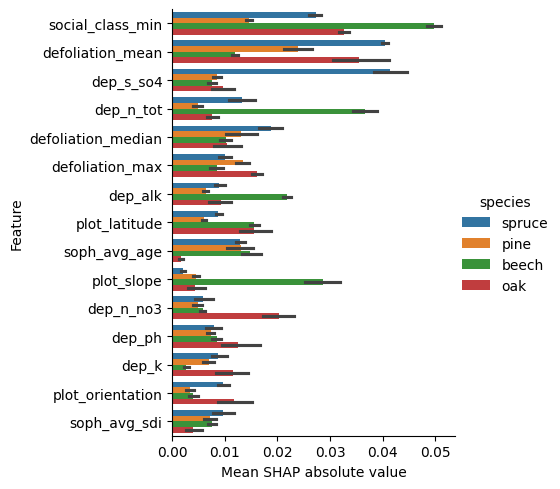

In [11]:
features = results.X.columns
top_n = 15

feature_importances = (
    pl.from_dicts(
        [
            {
                "species": species,
                "fold": fold,
                **dict(
                    zip(
                        features,
                        np.absolute(results.shap_values[fold].values).mean(axis=0),
                    )
                ),
            }
            for species, results in all_results.items()
            for fold in range(5)
        ]
    )
    .unpivot(
        on=pl.selectors.exclude("species", "fold"),  # type: ignore
        index=["species", "fold"],
        variable_name="feature",
        value_name="shap",
    )
    .with_columns(pl.col("shap").mean().over("feature").alias("importance"))
)

# Define order of features
feature_order = (
    feature_importances.group_by("feature")
    .agg(pl.col("importance").mean().alias("importance"))
    .sort("importance", descending=True)["feature"]
    .to_list()
)

sns.catplot(
    feature_importances,
    x="shap",
    y="feature",
    hue="species",
    kind="bar",
    order=feature_order[:top_n],
)
plt.xlabel("Mean SHAP absolute value")
plt.ylabel("Feature")

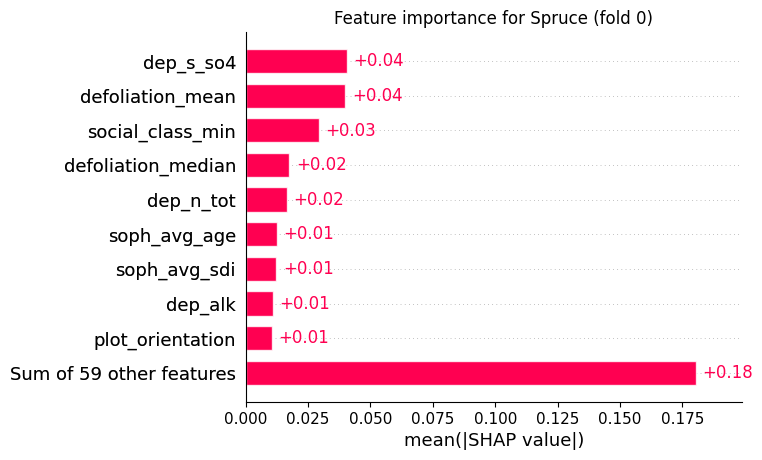

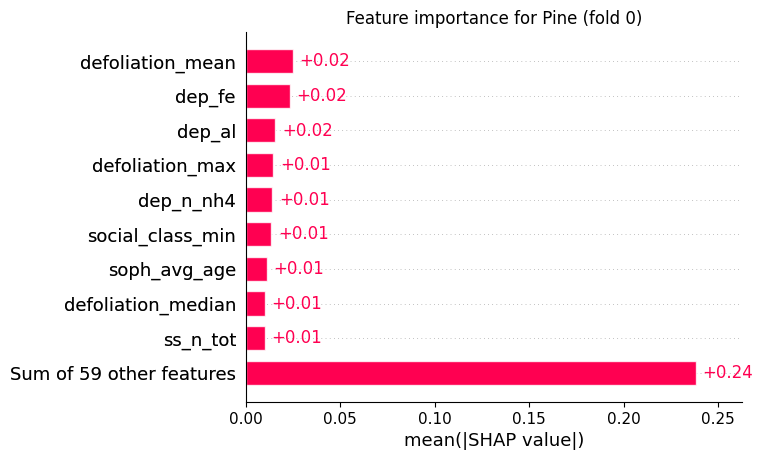

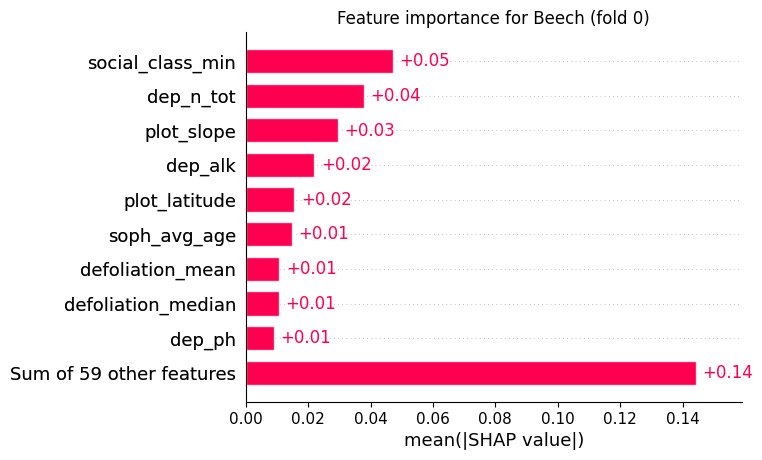

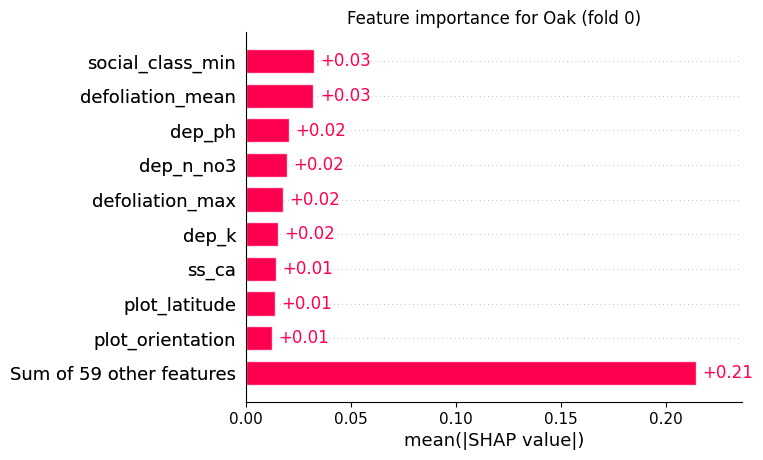

In [21]:
# Plot the top N features by species for a given fold
fold = 0  # Change this to plot for a different fold
for species, results in all_results.items():
    plt.figure()
    ax = shap.plots.bar(
        results.shap_values[fold],
        max_display=10,
        ax=plt.gca(),
        show=False,
    )
    ax.set_title(f"Feature importance for {species.capitalize()} (fold {fold})")

## Feature dependence plots

These plots show how the Shapley value varies as a function of feature value.

In [88]:
from scipy.optimize import curve_fit


def plot_dependence(
    results: ExperimentResults,
    feature: str,
    fold: int = 0,
    fit_curve: bool = False,
    xlim: tuple[float, float] | None = None,
    ylim: tuple[float, float] | None = None,
    ax: plt.Axes | None = None,
):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))

    if xlim is None:
        xlim = (
            np.nanmin(results.X[results.get_indices(fold, "all"), feature]),
            np.nanmax(results.X[results.get_indices(fold, "all"), feature]),
        )
    if ylim is None:
        ylim = (
            np.nanmin(results.shap_values[fold][:, feature].values),
            np.nanmax(results.shap_values[fold][:, feature].values),
        )

    # Enlarge slightly the limits for better visibility
    xlim = (xlim[0] - 0.05 * (xlim[1] - xlim[0]), xlim[1] + 0.05 * (xlim[1] - xlim[0]))
    ylim = (ylim[0] - 0.05 * (ylim[1] - ylim[0]), ylim[1] + 0.05 * (ylim[1] - ylim[0]))

    # Get the SHAP values for the selected feature
    shapley_values = cast(np.ndarray, results.shap_values[fold][:, feature].values)
    feature_values = results.X[results.get_indices(fold, "all"), feature].to_numpy()
    growth_values = results.y_true[results.get_indices(fold, "all")].to_numpy()

    # Order dataset by feature values
    order_idx = np.argsort(feature_values)
    feature_values = feature_values[order_idx]
    shapley_values = shapley_values[order_idx]
    growth_values = growth_values[order_idx]

    shap.plots.scatter(
        results.shap_values[fold][:, feature],
        # color=results.metadata[results.get_indices(fold, "all")]
        # .select(pl.col("plot_id").cast(pl.Categorical).to_physical())
        # .to_numpy().flatten(),
        alpha=0.4,
        ax=ax,
        show=False,
    )

    # Draw the line that indicates no effect
    ax.axhline(0, color="grey", linestyle="--")
    ax.text(xlim[1], ylim[1] / 20, "No effect", color="grey", ha="right")

    if fit_curve:
        # Fit a power law with vertical offset
        def func(x, a, b, c):
            return a * x**b + c

        # Get the SHAP values for the selected feature
        popt, _ = curve_fit(func, feature_values, shapley_values)

        # Plot the curve
        x = np.linspace(feature_values.min(), feature_values.max(), 100)
        ax.plot(
            x,
            func(x, *popt),
            color="red",
            label=f"y = {popt[0]:.2e} x^{popt[1]:.2f} + {popt[2]:.2f}",
        )

    ax.set_title(species.capitalize())
    ax.set_xlabel(feature)
    ax.set_ylabel("SHAP value")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    return ax

Text(0, 0.5, 'SHAP value')

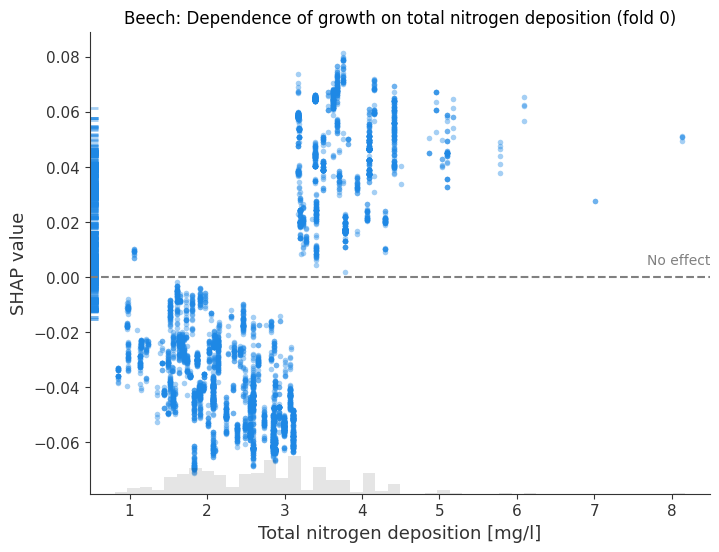

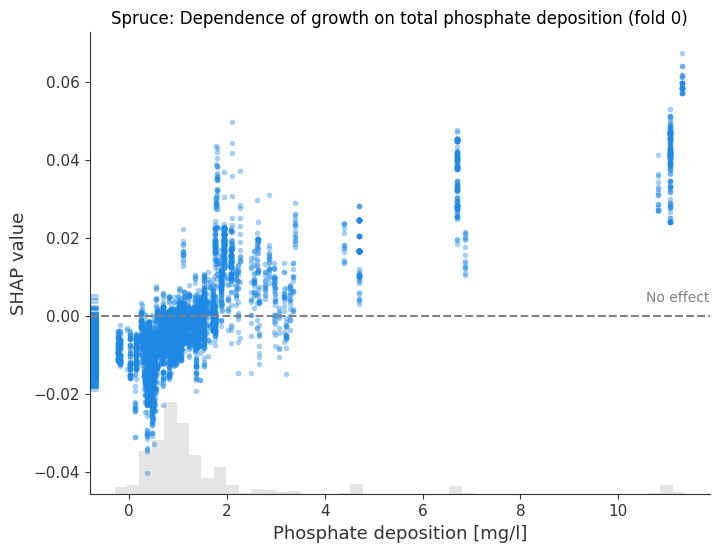

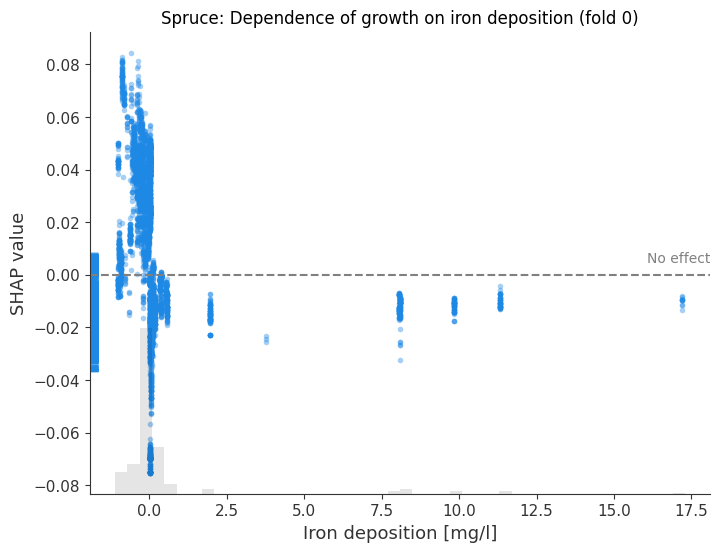

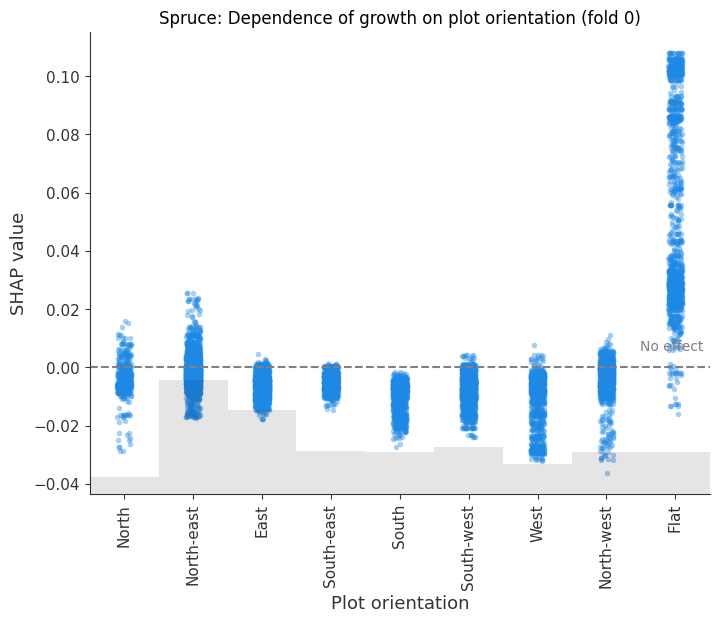

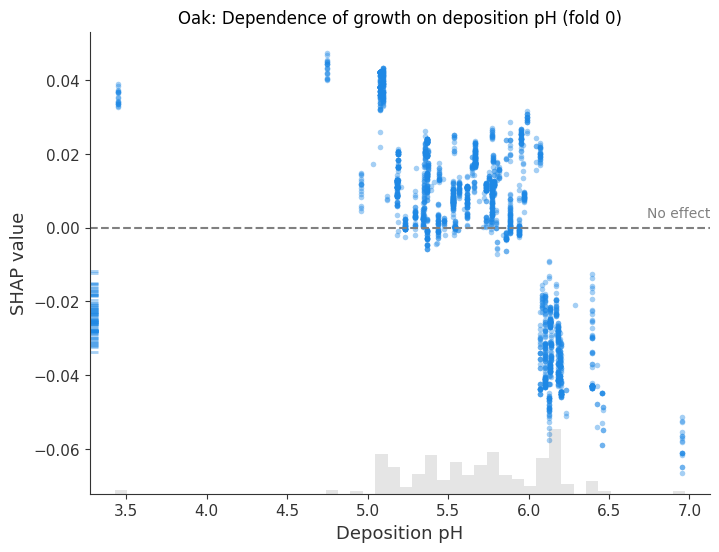

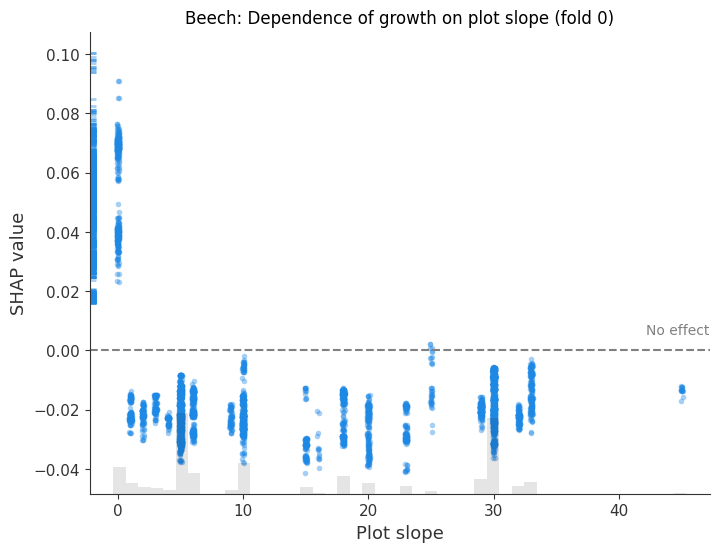

In [94]:
# Produce dependence plots for some key (species, feature) pairs
fold = 0  # Change this to plot for a different fold

# Beech: dependence on total nitrogen deposition
ax = plot_dependence(all_results["beech"], feature="dep_n_tot", fold=fold)
ax.set_title(f"Beech: Dependence of growth on total nitrogen deposition (fold {fold})")
ax.set_xlabel("Total nitrogen deposition [mg/l]")
ax.set_ylabel("SHAP value")

# Pine: dependence on deposition of phosphate
ax = plot_dependence(all_results["pine"], feature="dep_s_so4", fold=fold)
ax.set_title(
    f"Spruce: Dependence of growth on total phosphate deposition (fold {fold})"
)
ax.set_xlabel("Phosphate deposition [mg/l]")
ax.set_ylabel("SHAP value")

# Pine: dependence on iron deposition
ax = plot_dependence(all_results["pine"], feature="dep_fe", fold=fold)
ax.set_title(f"Spruce: Dependence of growth on iron deposition (fold {fold})")
ax.set_xlabel("Iron deposition [mg/l]")
ax.set_ylabel("SHAP value")

# Spruce: dependence on plot orientation
ax = plot_dependence(all_results["spruce"], feature="plot_orientation", fold=fold)
ax.set_title(f"Spruce: Dependence of growth on plot orientation (fold {fold})")
ax.set_xlabel("Plot orientation")
ax.set_ylabel("SHAP value")
ax.set_xticks(np.arange(9))  # 8 orientations + flat
ax.set_xticklabels(
    [
        "North",
        "North-east",
        "East",
        "South-east",
        "South",
        "South-west",
        "West",
        "North-west",
        "Flat",
    ],
    rotation=90,
)  # Adjust labels for better readability
ax.set_xlim(-0.5, 8.5)

# Oak: dependence on deposition pH
ax = plot_dependence(all_results["oak"], feature="dep_ph", fold=fold)
ax.set_title(f"Oak: Dependence of growth on deposition pH (fold {fold})")
ax.set_xlabel("Deposition pH")
ax.set_ylabel("SHAP value")

# Beech: dependence on plot slope
ax = plot_dependence(all_results["beech"], feature="plot_slope", fold=fold)
ax.set_title(f"Beech: Dependence of growth on plot slope (fold {fold})")
ax.set_xlabel("Plot slope")
ax.set_ylabel("SHAP value")

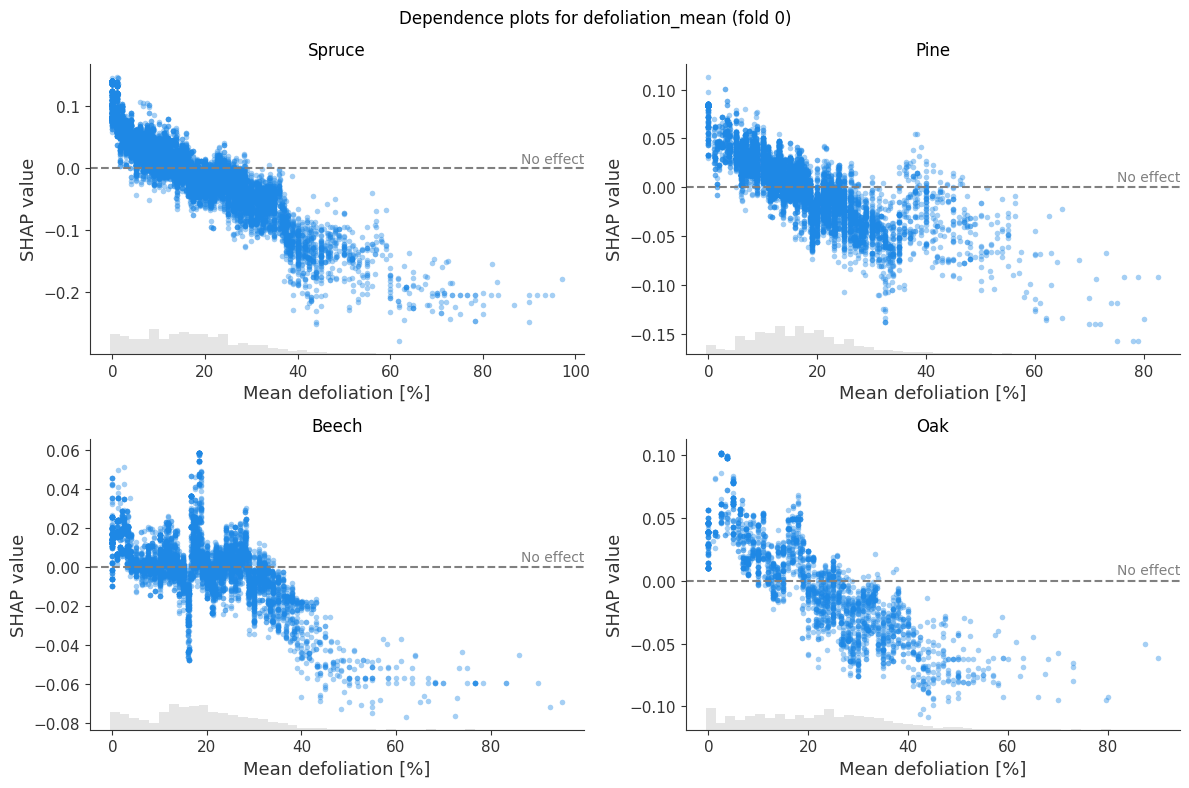

In [93]:
feature = "defoliation_mean"  # Change this to the feature you want to plot
interacting = "dep_fe"
fit_curve = False
fold = 0

# One plot per species (4 in total)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for species, ax in zip(all_species, axes.flatten()):
    plot_dependence(
        all_results[species],
        feature=feature,
        fold=fold,
        fit_curve=fit_curve,
        ax=ax,
    )
    ax.set_title(species.capitalize())
    ax.set_xlabel("Mean defoliation [%]")

if fit_curve:
    fig.suptitle(f"Dependence plots for {feature} with power law fit (fold {fold})")
else:
    fig.suptitle(f"Dependence plots for {feature} (fold {fold})")

plt.tight_layout()

# Species-specific plots

Hereafter we investigate a specific species and feature.

In [ ]:
species: Species = "spruce"
results = all_results[species]

## Feature interactions

We visualize the interaction between features by plotting two features against one each other.

In [ ]:
feature = "diameter_end"
# interacting = "defoliaton"

# Construct a DataFrame of the interaction values
feature_idx = results.X.columns.index(feature)

# Set axes
fig, ax = plt.figure(figsize=(6, 4)), plt.gca()

# Plot dependence plot with specific interaction
shap.plots.scatter(
    results.shap_values[fold][:, feature],
    # color=results.shap_values[fold][:, interacting].data,
    color=results.shap_values[fold],
    alpha=0.4,
    ax=ax,
    show=False,
)
plt.xlabel("Deposition of total nitrogen [mg / l]")
plt.ylabel("SHAP value")

# Set label of colorbar
ax.collections[0].colorbar.set_label("Tree Diameter [cm]")

In [ ]:
from explain import plot_ceteris_paribus_profile

fold = 0

X, _, y_pred = results.get_data(fold, "test")

# Plot 4 profiles for the selected feature
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

y_vec = y_pred.to_numpy()

for i, ax in enumerate(axes.flat):
    if i == 0:
        # Take 5 growth rates in the 5th percentile
        low, high = np.min(y_vec), np.percentile(y_vec, 5)
    elif i == 1:
        # Take 5 growth rates in the [20, 30] percentile
        low, high = (
            np.percentile(y_vec, 20),
            np.percentile(y_vec, 35),
        )
    elif i == 2:
        # Take 5 growth rates in the [70, 80] percentile
        low, high = (
            np.percentile(y_vec, 70),
            np.percentile(y_vec, 80),
        )
    else:
        # Take 5 growth rates in the 95th percentile
        low, high = np.percentile(y_vec, 95), np.max(y_vec)

    plot_period_indices = np.random.choice(
        np.argwhere((y_vec >= low) & (y_vec < high)).flatten(),
        5,
    )
    title = f"Growth rates between [{low:.2f}, {high:.2f}]"

    for idx in plot_period_indices:
        feature_range, y_pred = plot_ceteris_paribus_profile(
            results.estimators[fold], X, idx, feature, ax=ax
        )
    ax.set_title(title)
    # ax.set_ylim([0.2, 0.8])

plt.tight_layout()

## Explain a subset of the data

We explain only data within:

- A given climatic area (`boreal`, `high_altitude`, `dry`).

In [ ]:
from data import load_data

split = "all"
min_samples = 250

# Load the data and the corresponding results
data = load_data(species)
results = all_results[species]

# Map each category to a Polar expression to retrieve the corresponding indices
category_idx_expr = {
    "boreal": pl.arg_where(pl.col("plot_latitude") >= 500000),
    "temperate": pl.arg_where(pl.col("plot_latitude") < 500000),
    "high_altitude": pl.arg_where(pl.col("plot_altitude") >= 1000),
    "low_altitude": pl.arg_where(pl.col("plot_altitude") <= 200),
    "hot": pl.arg_where(pl.col("soph_avg_temp") >= 13.5),
    "cold": pl.arg_where(pl.col("soph_avg_temp") <= 10),
    "flat": pl.arg_where(pl.col("plot_slope") <= 5),
    "hilly": pl.arg_where(pl.col("plot_slope") > 20),
    "dry": pl.arg_where(pl.col("soph_avg_precip") < 400),
    "humid": pl.arg_where(pl.col("soph_avg_precip") > 800),
}

shap_values = []
categories = []

for label, filter in category_idx_expr.items():
    indices = data.select(filter).to_series().to_numpy()

    if len(indices) < min_samples:
        print(f"Not enough samples for {label}")
        continue

    features = results.X[indices, :].to_pandas()
    shap_np = cast(np.ndarray, results.shap_values[fold][indices].values)

    for idx in range(shap_np.shape[0]):
        shap_values.append(shap_np[idx, :])

    categories.extend([label] * shap_np.shape[0])

# Plot the feature importances by category
df = (
    pl.from_numpy(np.absolute(np.stack(shap_values, axis=1).T), schema=results.features)
    .with_columns(pl.Series("condition", categories))
    .unpivot(
        on=pl.selectors.exclude("condition"),
        variable_name="feature",
        value_name="importance",
        index=["condition"],
    )
    .filter(pl.col("condition").is_in(["boreal", "high_altitude", "dry", "hot"]))
)

sns.catplot(
    df,
    x="importance",
    y="feature",
    hue="condition",
    kind="bar",
    order=feature_order[:10],
)
plt.xlabel("Feature importance (mean absolute SHAP value)")
plt.ylabel("Feature")
plt.title(f"Feature importances by condition (species = {species.capitalize()})")

In [ ]:
# Plot dependence plots for the selected feature by category
feature = "diameter_end"
interacting = ""

# 2x2 grid for the 4 categories
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Define x- and y-axis limits based on global min and max values
x_min = data[feature].min()
x_max = data[feature].max()
y_min = np.min(results.shap_values[fold][:, feature].values)
y_max = np.max(results.shap_values[fold][:, feature].values)

# Background points (temperate)
background_indices = data.select(category_idx_expr["temperate"]).to_series().to_numpy()

for idx, conditions in enumerate(["boreal", "high_altitude", "dry", "hot"]):
    indices = data.select(category_idx_expr[conditions]).to_series().to_numpy()

    if len(indices) < 25:
        print(f"Not enough samples for {conditions}")
        continue

    ax = axes[idx]

    shap.plots.scatter(
        results.shap_values[fold][background_indices, feature],
        ax=ax,
        alpha=0.05,
        show=False,
        hist=False,
        color="grey",
    )

    shap.plots.scatter(
        results.shap_values[fold][indices, feature],
        ax=ax,
        alpha=0.4,
        show=False,
        # Iterate on tab10 colors
        color=plt.cm.tab10(idx),
    )

    # Draw the line that indicates no effect with a label
    ax.axhline(0, color="grey", linestyle="--")
    ax.text(x_max, y_max / 20, "No effect", color="grey", ha="right")

    ax.set_title(conditions.capitalize().replace("_", " "))
    ax.set_xlabel(feature)
    ax.set_ylabel("SHAP values")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

plt.tight_layout()

In [ ]:
# Visualize Shapley values using t-SNE
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Build a dataframe of shapley values across all species
df_shap = []
species_col = []
plot_id_col = []
for species, results in all_results.items():
    for fold in range(5):
        df_shap.append(results.shap_values[fold].values)
        species_col.extend([species] * len(df_shap[-1]))
        plot_id_col.extend(results.metadata["plot_id"].to_numpy())

# Build a dataframe of SHAP values, downsampled to 20,000 samples
df_shap = (
    pl.from_numpy(np.concatenate(df_shap, axis=0), schema=results.features)
    .with_columns(pl.Series("species", species_col), pl.Series("plot_id", plot_id_col))
    .select("species", "plot_id", pl.exclude("species", "plot_id"))
).sample(n=20000)

# Standardize the data
scaler = StandardScaler()
X_shap = np.nan_to_num(
    scaler.fit_transform(df_shap.select(pl.exclude("species")).to_numpy())
)

# Train the t-SNE model
tsne = TSNE(n_components=2, perplexity=100, early_exaggeration=20)
X_tsne = tsne.fit_transform(X_shap)

In [ ]:
# Use seaborn to generate a scatter plot of the t-SNE results

ax = sns.scatterplot(
    data=df_shap.with_columns(
        pl.Series("tsne_x", X_tsne[:, 0]), pl.Series("tsne_y", X_tsne[:, 1])
    ).to_pandas(),
    x="tsne_x",
    y="tsne_y",
    hue="species",
    alpha=0.5,
    palette="muted",
    s=5,
    legend="brief",
)

ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")

plt.tight_layout()

In [ ]:
# Produce a zoom in a specific region
x_bounds = [0, 40]
y_bounds = [-40, 0]

# Create 2 subplots of the zoomed region: one for the species and one for the plot_id

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, col in zip(axes, ["species", "plot_id"]):
    sns.scatterplot(
        data=df_shap.with_columns(
            pl.Series("tsne_x", X_tsne[:, 0]), pl.Series("tsne_y", X_tsne[:, 1])
        ).to_pandas(),
        x="tsne_x",
        y="tsne_y",
        hue=col,
        alpha=0.9,
        palette="muted" if col == "species" else "dark",
        legend=False,
        s=10,
        ax=ax,
    )

    ax.set_xlim(x_bounds)
    ax.set_ylim(y_bounds)

    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")

    plt.tight_layout()

## Feature interactions

We can compute the Shapley interactions using `get_shap_interactions`, which returns a tensor `(# samples, # features, # features)`, where each slice along the first axis is a symmetric matrix of interaction values, whose each row sums to the Shapley value for this feature. The diagonal entries represent the "main effect" attributed to that feature, whereas other entires represent the first-order interactions with every other feature.

In [ ]:
from explain import plot_interaction_matrix

top_n_features = (
    feature_importances.select("feature", "importance")
    .unique()
    .sort("importance", descending=True)
    .head(20)["feature"]
    .to_list()
)

interactions = {}
indices = {}

# Loop over the species
for species in all_species:
    results = all_results[species]

    # Plot the mean absolute interaction values for the selected feature as a heatmap
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    interactions[species], indices[species] = plot_interaction_matrix(
        results, top_n=top_n_features, ax=ax, vmax=0.005
    )

    plt.tight_layout()
    plt.title(f"Interactions for {species}")

    plt.savefig(f"figures/{species}-interactions-mean.png")

In [ ]:
interactions_matrix = interactions[species]
interactions_matrix.shape

np.vectorize(lambda m: m / np.sum(m, axis=1), signature="(m,m)->(m,m)")(
    interactions_matrix
)

In [ ]:
import networkx as nx

# Find all pair of features with a significant interaction
species = "spruce"
cutoff = 3e-3

results = all_results[species]
interactions_matrix = interactions[species]

interactions_matrix = np.absolute(interactions_matrix).mean(axis=0)
adjacency_matrix = np.triu(interactions_matrix, k=1)
adjacency_matrix[adjacency_matrix < cutoff] = 0.0

# Build graph from adjacency matrix
G = cast(
    nx.Graph,
    nx.from_numpy_array(
        adjacency_matrix,
        edge_attr="interaction",
        nodelist=results.features,
    ),
)

# Trim nodes without any connection
G.remove_nodes_from(list(nx.isolates(G)))

# Display graph with a circular layout
plt.figure(figsize=(12, 12))
pos = nx.circular_layout(G)

# Draw edges with a width proportional to the interaction strength
nx.draw_networkx_edges(
    G, pos, width=[G[u][v]["interaction"] * 1000 for u, v in G.edges()]
)

# Draw labels for the edges up in scientific notation with 2 decimal places
edge_labels = {
    k: f"{v:.2e}" for k, v in nx.get_edge_attributes(G, "interaction").items()
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Draw labels for the nodes while avoiding overlap
nx.draw_networkx_labels(
    G,
    pos,
    font_size=12,
    font_color="black",
    bbox=dict(facecolor="lightblue", boxstyle="round,pad=0.5,rounding_size=0.5"),
)
plt.title(f"Interaction graph for {species}")

In [ ]:
# Produce a plot to illustrate the interaction between two features
feature_idx = results.features.index("dep_fe")
interacting_idx = results.features.index("dep_p_po4")

plt.figure(figsize=(12, 8))

# Plot the interaction values for the selected feature
plt.scatter(
    results.X[indices[species], feature_idx].to_numpy(),
    results.X[indices[species], interacting_idx].to_numpy(),
    c=interactions[species][:, feature_idx, interacting_idx],
    cmap="coolwarm",
    alpha=0.5,
)

# Set labels for the x- and y-axis
plt.xlabel("Deposition of nitrogen")
plt.ylabel("Deposition of iron")

# Set log scale for the x- and y-axis
plt.xscale("log")
plt.yscale("log")


# plt.scatter()